In [60]:
import glob
from datetime import date

import pandas as pd

import altair as alt

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['svg.fonttype'] = 'none'

In [100]:
ministry_mapping = {
    'BBk': 'BBank',
    'BK Amt': 'BK',
    'BMELV': 'BMEL',
    'BMELVV': 'BMEL',
    'BMVBS': 'BMVI',
    'BPräsA': 'BPrA',
    'BMJ': 'BMJV',
    'BMJVV': 'BMJV',
    'BMVBS': 'BMVI',
    'BMUB': 'BMU',
}

def load_dataframe(filename):
    year = int(filename.split('_')[-1].split('.')[0])
    df = pd.read_csv(filename).fillna(0)
    df = df.rename(columns={'Ressort': 'name'})
    df = df[~df['name'].str.contains('Gesamt')]
    df['year'] = date(year, 1, 1)
    df['year'] = pd.to_datetime(df['year'])
    df['gb'] = df['name'].str.contains('GB')
    df['name'] = df['name'].str.replace(' GB', '')
    df['name'] = df['name'].str.replace('*', '', regex=True).str.replace('\d', '', regex=True).str.strip()
    for k, v in ministry_mapping.items():
        df['name'] = df['name'].str.replace('^' + k + '$', v, regex=True)
    df = df.rename(columns={k: k.strip().replace(' ', '_') for k in df.columns})
    
    if not 'sonstige_Erledigung' in df:
        print(filename)
        df['sonstige_Erledigung'] = 0
    
    return df

In [111]:
filenames = glob.glob('data/ifg_statistik_*.csv')

required_columns = ["name", "year", "Eingang_Erstanträge", "Eingang_Klagen", "Informationszugang_gewährt",
                    "Informationszugang_teilweise_gewährt", "Informationszugang_abgelehnt",
                   "sonstige_Erledigung", "Gebühr_erhoben", "Eingang_Widersprüche"]
all_columns = []
dfs = []
errors = []

for filename in filenames:
    # load file
    df = load_dataframe(filename)
    dfs.append(df)
    
    # make sure our data isn't hot garbage
    columns = list(df.columns)
    for col in required_columns:
        if not col in columns:
            errors.append("{} missing in {}".format(col, df['year'][0].year))
    all_columns += columns

print('\n'.join(errors))
assert len(errors) == 0

df = pd.concat(dfs).filter(items=required_columns)
df.to_csv('ifg_statistik.csv', index=False)

In [79]:
df.head()

,name,year,Eingang_Erstanträge,Eingang_Klagen,Informationszugang_gewährt,Informationszugang_teilweise_gewährt,Informationszugang_abgelehnt,sonstige_Erledigung,Gebühr_erhoben,Eingang_Widersprüche
0,BK,2015-01-01,221.0,3.0,33.0,26.0,45.0,104.0,21.0,4.0
1,BK,2015-01-01,16.0,0.0,0.0,0.0,10.0,6.0,0.0,0.0
3,BMAS,2015-01-01,67.0,6.0,26.0,11.0,15.0,14.0,13.0,8.0
4,BMAS,2015-01-01,867.0,14.0,730.0,37.0,38.0,58.0,27.0,26.0
6,AA,2015-01-01,349.0,6.0,80.0,35.0,31.0,185.0,43.0,9.0


## Eingang Erstanträge über die Jahre

(0.0, 58850.25)

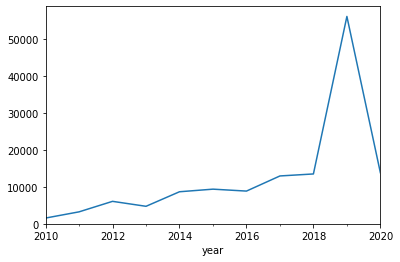

In [80]:
df.groupby('year')['Eingang_Erstanträge'].sum().plot()
plt.ylim(0)

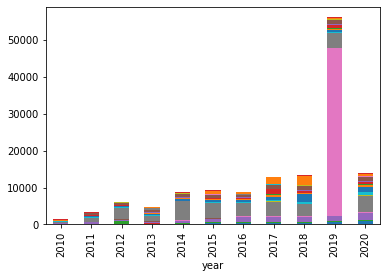

In [81]:
ax = df.groupby([df.year.dt.year, 'name'])['Eingang_Erstanträge'].sum().unstack().plot(kind='bar', stacked=True)
ax.legend().set_visible(False)

In [82]:
alt.Chart(df).mark_bar().encode(
    color='name',
    x='year',
    y='Eingang_Erstanträge',
    tooltip='name'
).interactive()

alt.Chart(...)

In [116]:
out_group = df.groupby(['name', 'year'])[required_columns].sum()
out_group['granted'] = out_group[['Informationszugang_gewährt', 'Informationszugang_teilweise_gewährt']].sum(1)
out_group['not_granted'] = out_group[['Informationszugang_abgelehnt', 'sonstige_Erledigung']].sum(1)
out_group['count'] = out_group['granted'] + out_group['not_granted']

out_group['transparency'] = out_group['granted'] / out_group['count'] * 100
out_group['transparency'] = out_group['transparency'].round()

out_group['filed_requests'] = out_group['Eingang_Erstanträge']
out_group['fees_charged'] = out_group['Gebühr_erhoben']
out_group['filed_objections'] = out_group['Eingang_Widersprüche']
out_group['filed_lawsuits'] = out_group['Eingang_Klagen']


out_group = out_group.reset_index()

out_cols = ['name', 'year', 'granted', 'not_granted', 'count', 'transparency', 'filed_requests',
           'fees_charged', 'filed_objections', 'filed_lawsuits']
out_group = out_group.filter(items=out_cols)
out_group['year'] = pd.to_datetime(out_group['year']).dt.year
out_group.to_csv('data.csv', index=False)